In [564]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import classification_report

In [565]:
fightData = pd.read_csv("https://raw.githubusercontent.com/perenciolo/pokemon-predictions/master/server/src/data/ufc/data.csv")  # fights Dataset
fightData=fightData.drop(columns = ["Referee", "date","location","title_bout","no_of_rounds",'R_Stance','B_Stance'])
fightData.head()

,R_fighter,B_fighter,Winner,weight_class,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,...,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Red,Bantamweight,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.60000,51.200000,17.400000,0.600000,...,2.0,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Red,Women's Flyweight,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,12.800000,9.60000,101.700000,32.000000,8.100000,...,2.0,24.571429,14.142857,10.571429,7.857143,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Red,Lightweight,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,8.419355,5.83871,84.548387,38.064516,1.741935,...,1.0,14.466667,8.133333,2.800000,0.733333,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Blue,Bantamweight,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,6.000000,3.75000,94.250000,26.750000,1.750000,...,2.0,20.250000,13.375000,6.875000,5.625000,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0

In [566]:
print(fightData.nunique())

R_fighter                1334
B_fighter                1774
Winner                      3
weight_class               14
B_current_lose_streak       7
                         ... 
R_Height_cms               23
R_Reach_cms                24
R_Weight_lbs               58
B_age                      31
R_age                      29
Length: 138, dtype: int64


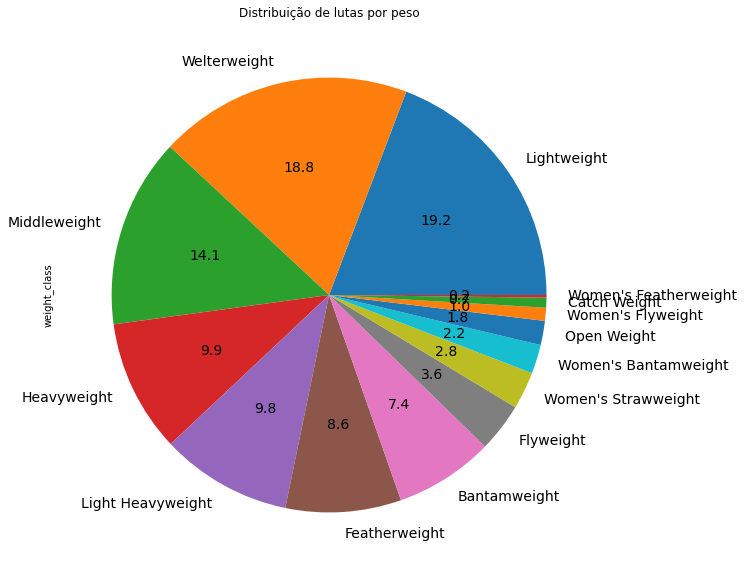

In [567]:
plot = (fightData['weight_class'].value_counts().plot.pie(figsize = (10, 10), autopct='%1.1f', fontsize = 14))
plt.title("Distribuição de lutas por peso")
plt.show(plot)


Text(27.125, 0.5, 'Total de Knockouts')

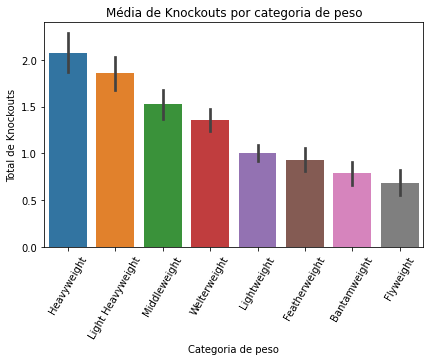

In [568]:
plt.title('Média de Knockouts por categoria de peso')
plt.xticks(rotation=60)
plt.tight_layout()
sns.barplot(x="weight_class",y='R_win_by_KO/TKO', data=fightData,estimator=np.mean,order=['Heavyweight','Light Heavyweight','Middleweight','Welterweight','Lightweight','Featherweight','Bantamweight','Flyweight'])
plt.xlabel('Categoria de peso')
plt.ylabel('Total de Knockouts')

In [569]:
fighters = pd.concat([fightData['R_fighter'],fightData['B_fighter']],ignore_index=True).fillna(0)
fighters

0                Henry Cejudo
1        Valentina Shevchenko
2               Tony Ferguson
3               Jimmie Rivera
4                 Tai Tuivasa
                 ...         
10283            Kevin Rosier
10284           Patrick Smith
10285           Art Jimmerson
10286            Zane Frazier
10287              Teila Tuli
Length: 10288, dtype: object

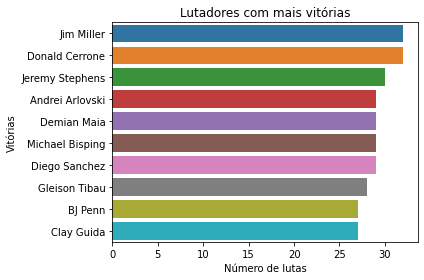

In [570]:
mostWinners = fighters.value_counts().sort_values(ascending=False).head(10)
sns.barplot(x=mostWinners, y=mostWinners.index)
plt.title("Lutadores com mais vitórias")
plt.ylabel("Vitórias")
plt.xlabel("Número de lutas")
plt.tight_layout()

In [571]:
from datetime import datetime
import time
rawFightersData = pd.read_csv("https://raw.githubusercontent.com/perenciolo/pokemon-predictions/master/server/src/data/ufc/raw_fighter_details.csv")  # fighters Dataset
rawFightersData = rawFightersData.dropna()
# rawFightersData['DOB'] = pd.TimedeltaIndex(datetime.today().strftime("%Y%m%d"), rawFightersData['DOB'])
todayDF = rawFightersData['DOB'].copy()
rawFightersData['TODAY']=pd.to_datetime(datetime.today().strftime("%Y%m%d"))
rawFightersData['DOB'] = pd.to_datetime(todayDF)

def parse_date(td):
  resYear = float(td.days)/364.0                   # get the number of years including the the numbers after the dot
  resMonth = int((resYear - int(resYear))*364/30)  # get the number of months, by multiply the number after the dot by 364 and divide by 30.
  resYear = int(resYear)
  return resYear

def parseHeight(height):
  height = height.replace('"','').replace("'",'')
  feet = float(height.split()[0])
  inches = float(height.split()[1])
  result = parseInchesToCm(feet*12) + parseInchesToCm(inches)
  return float("{:10.2f}".format(result))

def parseWeight(weight):
  weight = float(weight.split()[0])
  result =weight * 0.453592 
  return float("{:10.2f}".format(result))

def parseInchesToCm(inch):
  if type(inch) is str:
    inch = float(inch.replace('"',''))
  result = inch * 2.54
  return float("{:10.2f}".format(result))
    
rawFightersData['Age'] =[parse_date(start-end) for start, end in zip(rawFightersData['TODAY'], rawFightersData['DOB'])]
rawFightersData['Age'] =rawFightersData['Age'].astype(int)
rawFightersData['Height'] =rawFightersData['Height'].apply(parseHeight)
rawFightersData['Weight'] =rawFightersData['Weight'].apply(parseWeight)
rawFightersData['Reach'] =rawFightersData['Reach'].apply(parseInchesToCm)
rawFightersData.head()

,fighter_name,Height,Weight,Reach,Stance,DOB,TODAY,Age
10,Aaron Phillips,175.26,61.23,177.80,Southpaw,1989-08-05,2021-03-01,31
11,Aaron Riley,172.72,70.31,175.26,Southpaw,1980-12-09,2021-03-01,40
12,Aaron Rosa,193.04,92.99,198.12,Orthodox,1983-05-28,2021-03-01,37
13,Aaron Simpson,182.88,77.11,185.42,Orthodox,1974-07-20,2021-03-01,46
17,Abdul Razak Alhassan,177.80,77.11,185.42,Orthodox,1985-08-11,2021-03-01,35


Text(0.5, 1.0, 'Distribuição geral de idades dos(as) lutadores(as) do UFC')

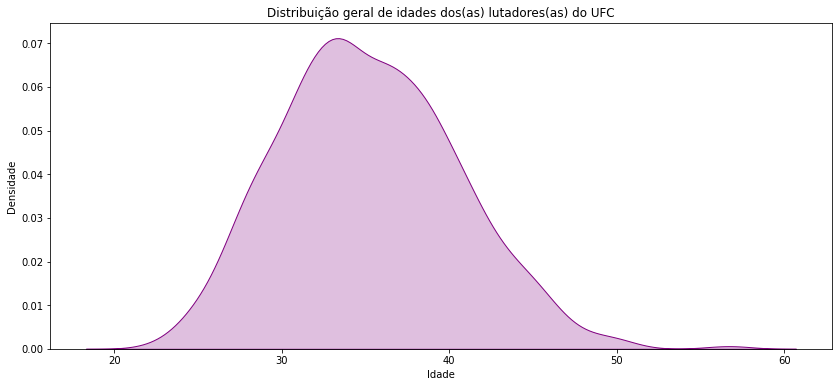

In [572]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(rawFightersData['Age'].dropna(), shade=True, color="purple")
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição geral de idades dos(as) lutadores(as) do UFC')

Text(0.5, 1.0, 'Distribuição geral de altura dos(as) lutadores(as) do UFC')

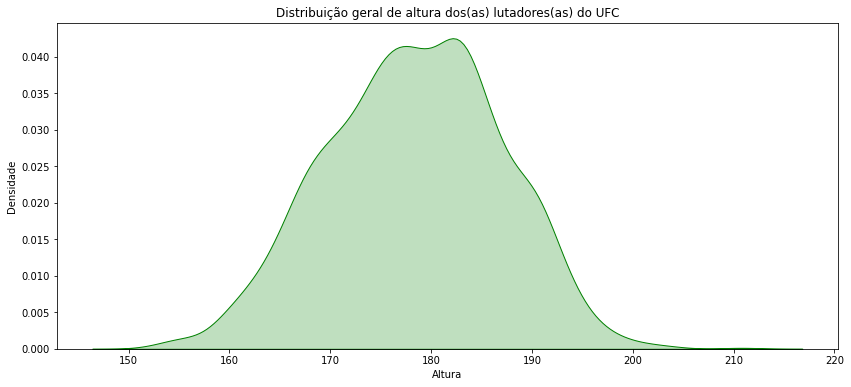

In [573]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(rawFightersData['Height'].dropna(), shade=True, color="Green")
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição geral de altura dos(as) lutadores(as) do UFC')

Text(0.5, 1.0, 'Distribuição geral de alcance dos(as) lutadores(as) do UFC')

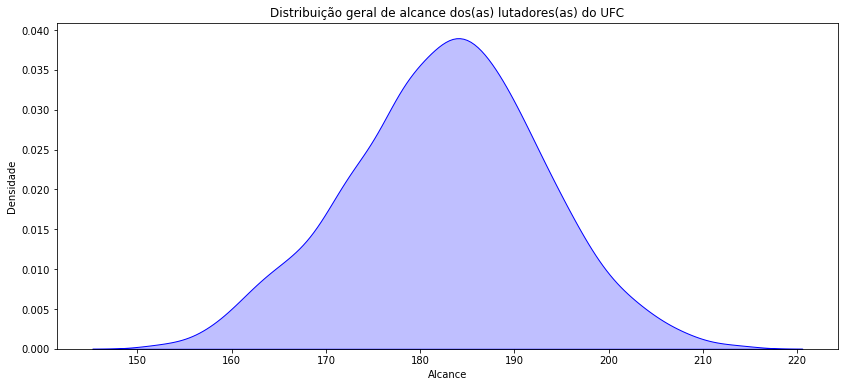

In [574]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(rawFightersData['Reach'].dropna(), shade=True, color="Blue")
plt.xlabel('Alcance')
plt.ylabel('Densidade')
plt.title('Distribuição geral de alcance dos(as) lutadores(as) do UFC')

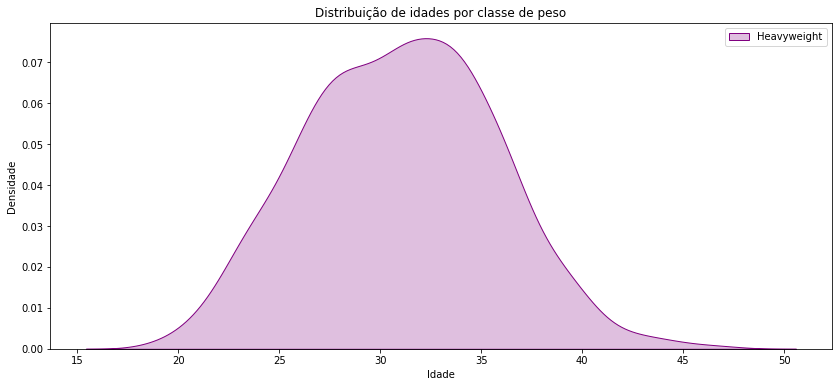

In [575]:
heavyweightData = (fightData.loc[fightData['weight_class'] == 'Heavyweight'])
lightHeavyweightData = fightData.loc[fightData['weight_class'] == 'Light Heavyweight']
middleweightData = fightData.loc[fightData['weight_class'] == 'Middleweight']
welterweightData = fightData.loc[fightData['weight_class'] == 'Welterweight']
lightweightData = fightData.loc[fightData['weight_class'] == 'Lightweight']
featherweightData = fightData.loc[fightData['weight_class'] == 'Featherweight']
bantamweightData = fightData.loc[fightData['weight_class'] == 'Bantamweight']
flyweightData = fightData.loc[fightData['weight_class'] == 'Flyweight']

fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([heavyweightData['R_age'],heavyweightData['B_age']]).dropna(), shade=True, color="purple", label='Heavyweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

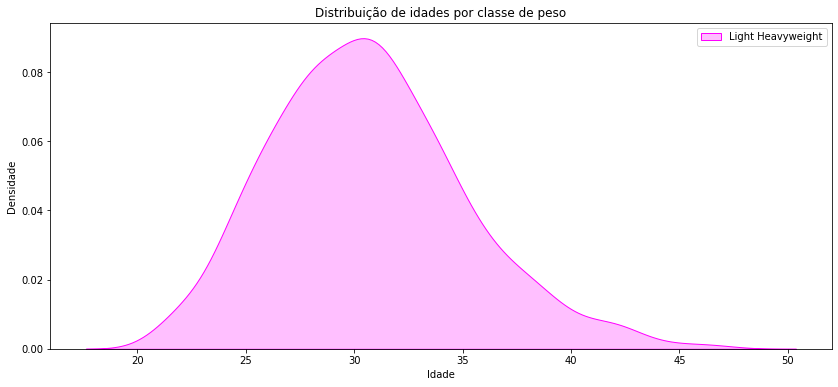

In [576]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([lightHeavyweightData['R_age'],lightHeavyweightData['B_age']]).dropna(), shade=True, color="magenta", label='Light Heavyweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

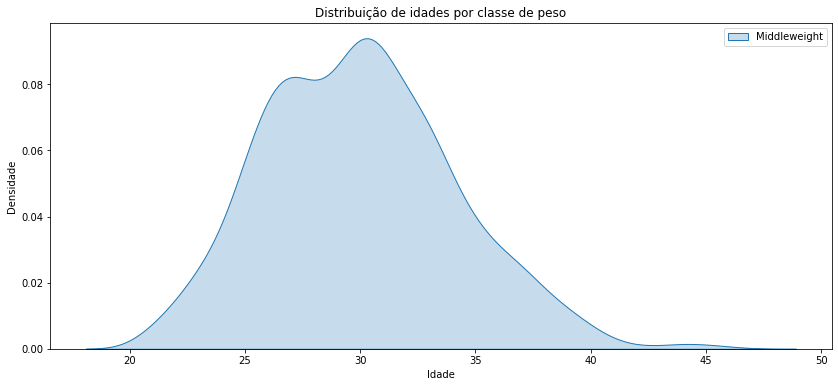

In [577]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([middleweightData['R_age'],middleweightData['B_age']]).dropna(), shade=True, label='Middleweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

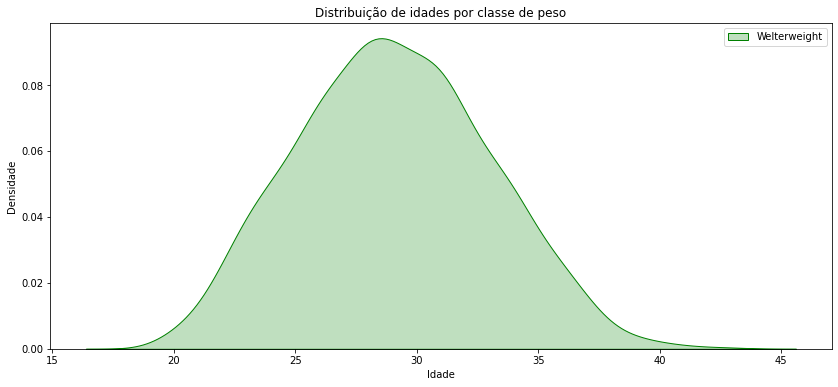

In [578]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([welterweightData['R_age'],welterweightData['B_age']]).dropna(), shade=True, color='Green', label='Welterweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

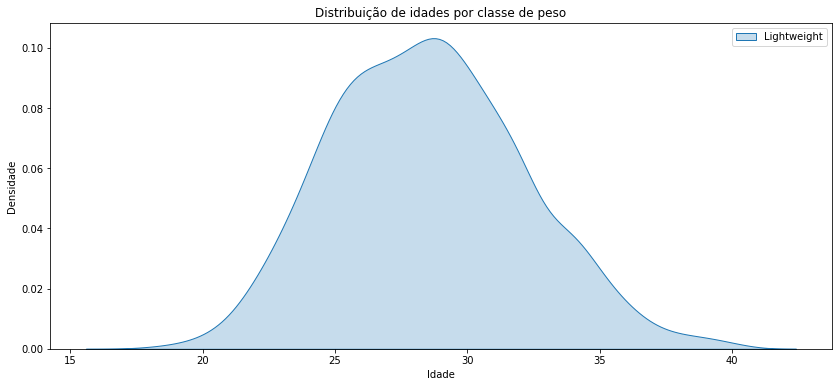

In [579]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([lightweightData['R_age'],lightweightData['B_age']]).dropna(), shade=True, label='Lightweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

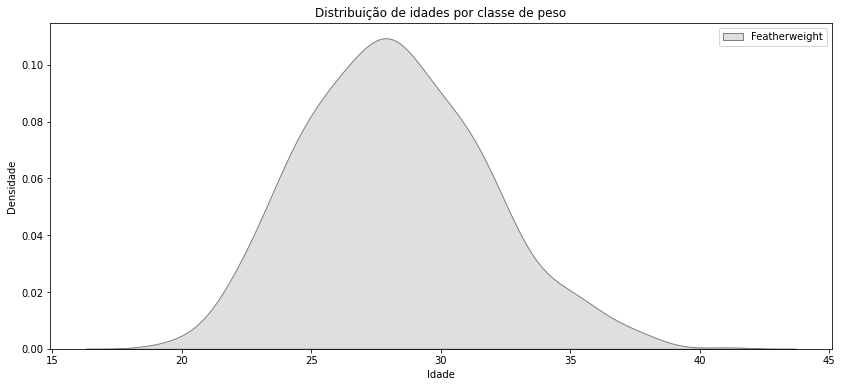

In [580]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([featherweightData['R_age'],featherweightData['B_age']]).dropna(), shade=True, color='Grey', label='Featherweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

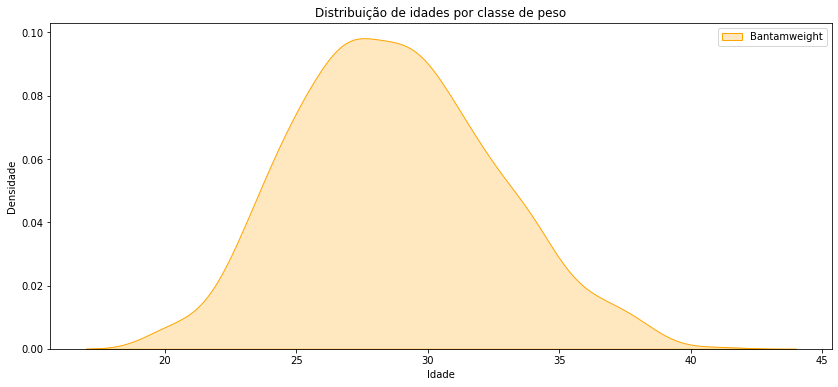

In [581]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([bantamweightData['R_age'],bantamweightData['B_age']]).dropna(), shade=True,color='orange',  label='Bantamweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

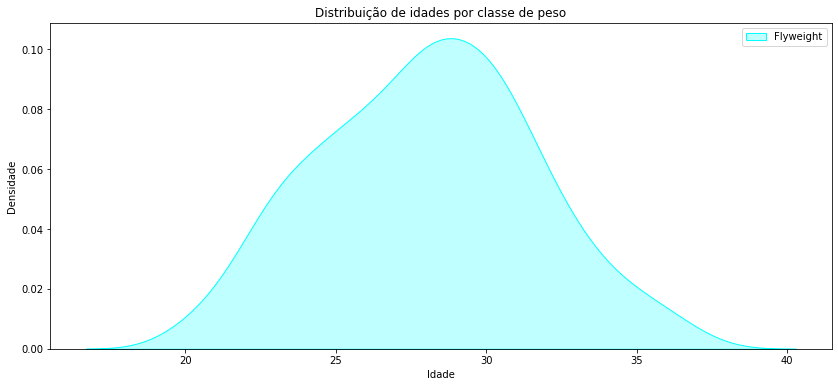

In [582]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([flyweightData['R_age'],flyweightData['B_age']]).dropna(), shade=True,color='Cyan',  label='Flyweight')
plt.xlabel('Idade')
plt.ylabel('Densidade')
plt.title('Distribuição de idades por classe de peso')
plt.legend()

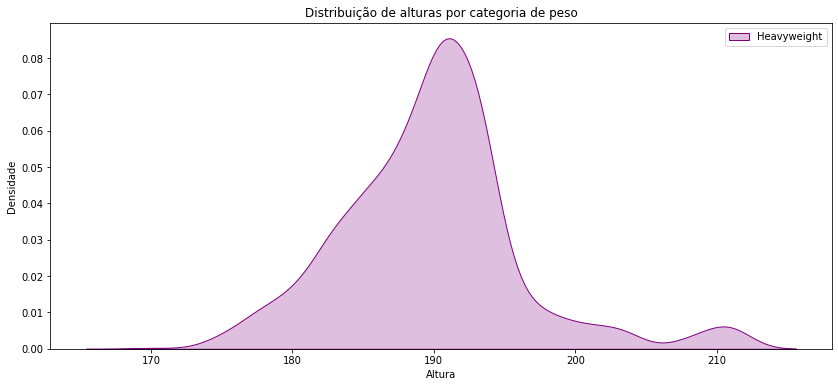

In [583]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([heavyweightData['R_Height_cms'],heavyweightData['B_Height_cms']]).dropna(), shade=True, color="purple", label='Heavyweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

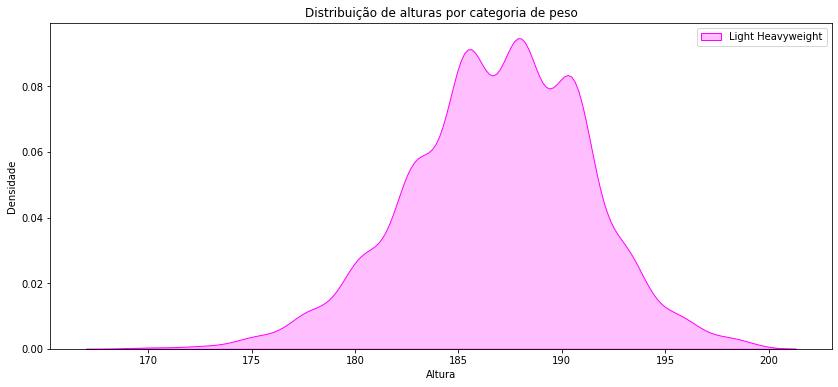

In [584]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([lightHeavyweightData['R_Height_cms'],lightHeavyweightData['B_Height_cms']]).dropna(), shade=True, color="magenta", label='Light Heavyweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

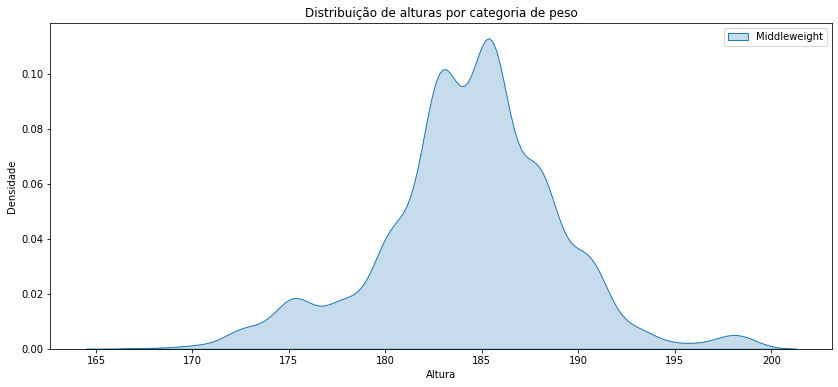

In [585]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([middleweightData['R_Height_cms'],middleweightData['B_Height_cms']]).dropna(), shade=True, label='Middleweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

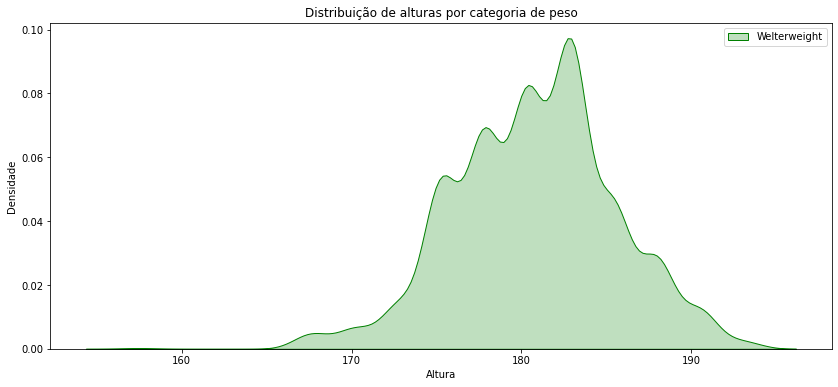

In [586]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([welterweightData['R_Height_cms'],welterweightData['B_Height_cms']]).dropna(), shade=True, color='Green', label='Welterweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

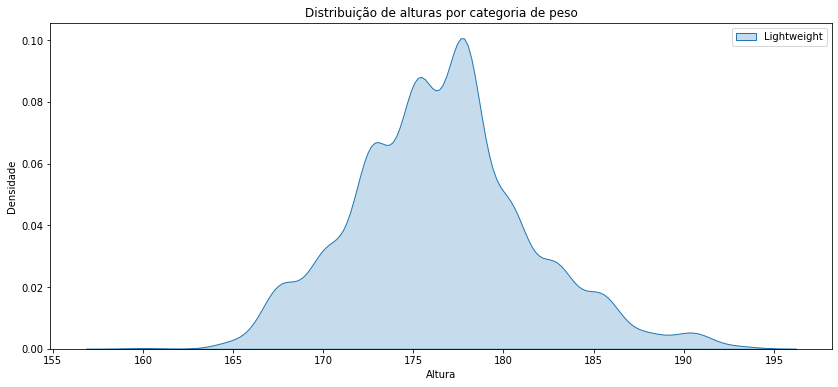

In [587]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([lightweightData['R_Height_cms'],lightweightData['B_Height_cms']]).dropna(), shade=True, label='Lightweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

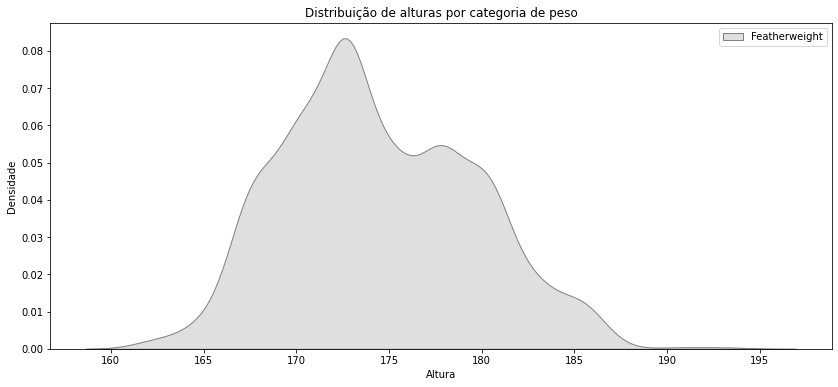

In [588]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([featherweightData['R_Height_cms'],featherweightData['B_Height_cms']]).dropna(), shade=True, color='Grey', label='Featherweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

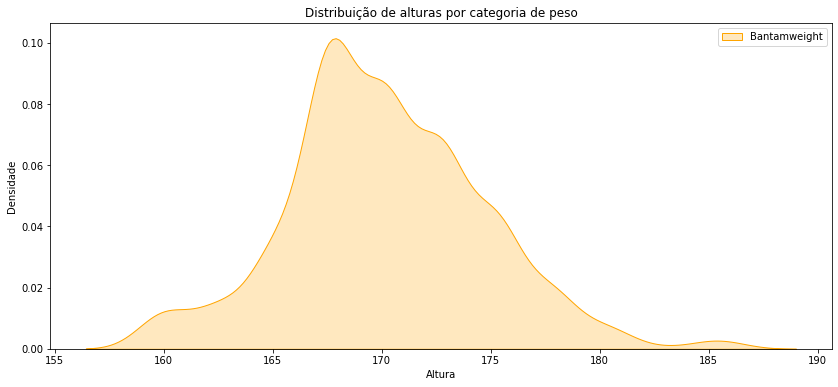

In [589]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([bantamweightData['R_Height_cms'],bantamweightData['B_Height_cms']]).dropna(), shade=True,color='orange',  label='Bantamweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

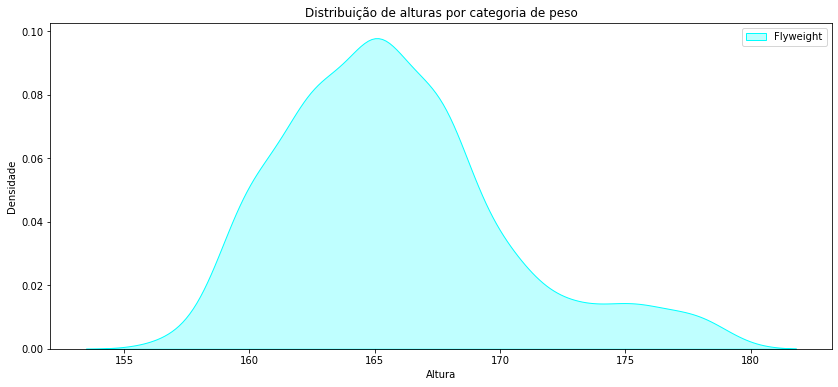

In [590]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(pd.concat([flyweightData['R_Height_cms'],flyweightData['B_Height_cms']]).dropna(), shade=True,color='Cyan',  label='Flyweight')
plt.xlabel('Altura')
plt.ylabel('Densidade')
plt.title('Distribuição de alturas por categoria de peso')
plt.legend()

In [591]:
# Fill the empty values with NA
fightData['weight_class'] = fightData['weight_class'].fillna('NA')
fightData.loc[:, 'Winner'].replace(['Blue','Red'], [0, 1], inplace=True)
fightData.head()

,R_fighter,B_fighter,Winner,weight_class,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,...,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,1,Bantamweight,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.60000,51.200000,17.400000,0.600000,...,2.0,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,1,Women's Flyweight,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,12.800000,9.60000,101.700000,32.000000,8.100000,...,2.0,24.571429,14.142857,10.571429,7.857143,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,1,Lightweight,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,8.419355,5.83871,84.548387,38.064516,1.741935,...,1.0,14.466667,8.133333,2.800000,0.733333,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,0,Bantamweight,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,6.000000,3.75000,94.250000,26.750000,1.750000,...,2.0,20.250000,13.375000,6.875000,5.625000,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0.000000,0

In [592]:
h1 = FeatureHasher(n_features=5, input_type='string')
d1 = h1.fit_transform(fightData["weight_class"])

In [593]:
# Convert to dataframe
d1 = pd.DataFrame(data=d1.toarray())

# Drop Type 1 and Type 2 column from Pokemon dataset and concatenate the above two dataframes.
fightData = fightData.drop(columns = ["weight_class"])
fightData = pd.concat([fightData, d1], axis=1)
fightData = fightData.replace(np.nan, 0)

In [594]:
fightData

,R_fighter,B_fighter,Winner,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,...,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,0,1,2,3,4
0,Henry Cejudo,Marlon Moraes,1,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.60000,51.200000,17.400000,0.600000,0.200000,...,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,162.56,162.56,135.0,31.0,32.0,1.0,-1.0,-2.0,0.0,-2.0
1,Valentina Shevchenko,Jessica Eye,1,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,12.800000,9.60000,101.700000,32.000000,8.100000,6.900000,...,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,165.10,167.64,125.0,32.0,31.0,-1.0,-1.0,1.0,-1.0,-1.0
2,Tony Ferguson,Donald Cerrone,1,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,8.419355,5.83871,84.548387,38.064516,1.741935,0.935484,...,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,180.34,193.04,155.0,36.0,35.0,-2.0,-4.0,-2.0,0.0,-1.0
3,Jimmie Rivera,Petr Yan,0,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,6.000000,3.75000,94.250000,26.750000,1.750000,1.250000,...,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0.000000,0.000000,115.125000,48.875000,20.0,690.25,0.0,0.0,1.0,4.0,1.0,0.0,0.0,6.0,162.56,172.72,135.0,26.0,29.0,1.0,-1.0,-2.0,0.0,-2.0
4,Tai Tuivasa,Blagoy Ivanov,0,0.0,1.0,0.0,17.000000,14.500000,2.

In [595]:
data = fightData.drop(columns = ["R_fighter", "B_fighter",'Winner'])
data = pd.concat([data, fightData['Winner'].replace(['Draw',-1])], axis=1)

In [596]:
data = np.asarray(data)

In [597]:
X = data[:,:-1].astype(int)
y = data[:, -1].astype(int)

In [598]:
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=.25,random_state=42)


In [599]:
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)
pred = model.predict(X_test)

In [600]:
print('Accuracy:', accuracy_score(pred,y_test))
print(classification_report(y_test,pred))

Accuracy: 0.6944012441679627
              precision    recall  f1-score   support

           0       0.49      0.21      0.29       390
           1       0.72      0.91      0.80       896

    accuracy                           0.69      1286
   macro avg       0.61      0.56      0.55      1286
weighted avg       0.65      0.69      0.65      1286

